# Projet

### Imports

In [15]:
# Imports
import glob, os
import pandas
import urllib
from SPARQLWrapper import SPARQLWrapper
import PIL.Image
from skimage import io
import ipywidgets
import matplotlib.pyplot as plt
import numpy
from sklearn.cluster import KMeans
from random import randint

### WikiBaseIntegrator Imports

In [16]:
from wikibaseintegrator import WikibaseIntegrator
from wikibaseintegrator.wbi_config import config

config['USER_AGENT'] = 'test'

## 1. Collecte de données

### Dataframe Functions

In [17]:
def getData(): # Prends les données au format JSON pour en faire une dataframe
    path = "data.json"
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def saveData(dataframe): # Enregistre la dataframe au format JSON
    path = "data.json"
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

def getUsers(): 
    path = "users.json"
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def saveUsers(dataframe):   
    path = "users.json"
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

### WikiBaseIntegrator Functions

In [34]:
wbi = WikibaseIntegrator()

def GetCountryLabelInFrench(itemID): #Permet de récupérer le label du pays en français à partir de son qualifier/ID WikiData
    item_data=wbi.item.get(itemID) #Récupère les données du monument
    country_id=item_data.claims.get('P17')[0].mainsnak.datavalue['value']['id'] #Récupère l'ID du pays
    country=wbi.item.get(country_id) #Récupère les données du pays
    return country.labels.get('fr').value #Retourne le label du pays en français

def AddCountryTags(dataframe): #Permet d'ajouter le tag du pays à chaque ligne du dataframe
    items_tuples=[]
    for i in range(len(dataframe.index)): # Récupère les IDs de toutes les lignes du dataframe
        itemID=dataframe._get_value(i,"entityID")
        items_tuples.append(itemID)
    for i in range(len(items_tuples)): # Ajoute le pays à chaque ligne du dataframe
        country = GetCountryLabelInFrench(items_tuples[i])
        dataframe.at[i, "tags"].append("#"+country)
    return dataframe

def GetArchitecturalStyle(styleID): #Permet de récupérer le nom du style architectural en français à partir de son qualifier/ID WikiData
    styleL=[]
    for i in range(len(styleID)): # Récupère les IDs de style architectural pour chaque ligne du dataframe
        style = wbi.item.get(styleID[i]) #Récupère les données du style architectural
        if style.labels.get('fr') is None: #Prise en charge du cas où le style n'a pas de nom en français
            style_name = style.labels.get('en').value
        else:
            style_name = style.labels.get('fr').value
        styleL.append("#"+style_name) #Ajoute le nom du style à la liste de résultat
    return styleL #Retourne le nom du style architectural

def AddStyleTags(dataframe): #Permet d'ajouter les tags des styles architecturaux à chaque ligne du dataframe
    for k in range(len(dataframe.index)): #On parcourt chaque ligne du dataframe
        style = GetArchitecturalStyle(dataframe._get_value(k,"style"))
        for l in range(len(style)): #On parcourt chaque indice de la liste de style (un monument peut avoir plusieurs styles)
            dataframe.at[k, "tags"].append(style[l])
    return dataframe

### Récupération du résultat d'une query Wikidata

In [30]:
size = 20
imagesPath = "./images/"

# Query de Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
query = """
SELECT ?item ?itemLabel ?pic (YEAR(?date) as ?year) ?style WHERE {
  ?item wdt:P31 wd:Q4989906;
    wdt:P18 ?pic;
    wdt:P571 ?date;
    wdt:P149 ?style.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT """
# On précise le nombre d'entrées que l'on veut
query = query + str(size)

# On récupère le résultat de la query
sparql.setQuery(query)
sparql.setReturnFormat("json")
results = sparql.query().convert()
print(results)

# On normalise les résultats pour pandas
array = []
for trainData in results["results"]["bindings"]:
    name = trainData["itemLabel"]["value"]
    format = trainData["pic"]["value"].split(".")[-1]
    path = f"{imagesPath}{name}.{format}"
    if "year" in trainData.keys():
        year = trainData["year"]["value"]
    else:
        year = None
    style = trainData["style"]["value"]
    array.append([name,  
                  trainData["pic"]["value"], 
                  trainData["item"]["value"].split(sep='/')[-1],
                  format,
                  path,
                  (),
                  None,
                  ['#monument'],
                  year,
                  style.split(sep='/')[-1]])
                  

dataframe = pandas.DataFrame(array, columns=["label", "link", "entityID", "format", "path", "size", "sizeCategory", "tags", "year","style"])

#On fusionne les lignes avec le même label en gardant les différents styles
dataframe = dataframe.groupby('label').agg({'link':'first', 'entityID':'first', 'format':'first', 'path':'first', 'size':'first', 'sizeCategory':'first','tags':'first', 'year':'first', 'style':list}).reset_index()

# On enregistre les données au format JSON
saveData(dataframe)

# Nettoyage du dossier /images
if not os.path.isdir('./images'):
  os.mkdir('./images')

# Nettoyage du dossier /images
else:
  files = glob.glob('./images/*')
  for f in files:
      os.remove(f)

dataframe

{'head': {'vars': ['item', 'itemLabel', 'pic', 'year', 'style']}, 'results': {'bindings': [{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1139113'}, 'style': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q46261'}, 'pic': {'type': 'uri', 'value': 'http://commons.wikimedia.org/wiki/Special:FilePath/Estibalizko%20santutegi%20erromanikoa.jpg'}, 'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Sanctuary of Nuestra Señora de Estíbaliz'}}, {'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q837979'}, 'style': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q176483'}, 'pic': {'type': 'uri', 'value': 'http://commons.wikimedia.org/wiki/Special:FilePath/Monasterio%20de%20Iranzu.%20Claustro.jpg'}, 'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Monastery of Iranzu'}, 'year': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '1176'}}, {'item': {'type': 'uri', 'value': 'http://www.wikid

,label,link,entityID,format,path,size,sizeCategory,tags,year,style
0,Castillo de Belmonte,http://commons.wikimedia.org/wiki/Special:File...,Q917896,jpg,./images/Castillo de Belmonte.jpg,(),None,[#monument],1456,[Q15011985]
1,Castle of the Marquises of the Vélez,http://commons.wikimedia.org/wiki/Special:File...,Q922097,JPG,./images/Castle of the Marquises of the Vélez.JPG,(),None,[#monument],1506,[Q4692]
2,Church of Nuestra Señora de la Asunción,http://commons.wikimedia.org/wiki/Special:File...,Q934947,jpg,./images/Church of Nuestra Señora de la Asunci...,(),None,[#monument],1764,"[Q37853, Q37853]"
3,Church of Santo Adriano de Tuñón,http://commons.wikimedia.org/wiki/Special:File...,Q942130,jpg,./images/Church of Santo Adriano de Tuñón.jpg,(),None,[#monument],801,[Q2748473]
4,Church of la Inmaculada Concepción,http://commons.wikimedia.org/wiki/Special:File...,Q965302,jpg,./images/Church of la Inmaculada Concepción.jpg,(),None,[#monument],1401,[Q2602891]
5,Hermitage of San Isidro,http://commons.wikimedia.org/wiki/Special:File...,Q920742,jpg,./images/Hermitage of San Isidro.jpg,(),None,[#monument],1650,[Q37853]
6,Hermitage of Santa María la Antigua,http://commons.wikimedia.org/wiki/Special:File...,Q926529,jpg,./images/Hermitage of Santa María la Antigua.jpg,(),None,[#monument],1200,[Q46261]
7,Hospital de la Santa Caridad,http://commons.wikimedia.org/wiki/Special:File...,Q858907,jpg,./images/Hospital de la Santa Caridad.jpg,(),None,[#monument],1682,[Q37853]
8,Monastery of Iranzu,http://commons.wikimedia.org/wiki/Special:File...,Q837979,jpg,./images/Monastery of Iranzu.jpg,(),None,[#monument],1176,[Q176483]
9,Plaza de España,http://commons.wikimedia.org/wiki/Special:File...,Q956018,jpg,./images/Plaza de España.jpg,(),None,[#monument],1928,"[Q5705264, Q5705264]"


### Téléchargement des Images

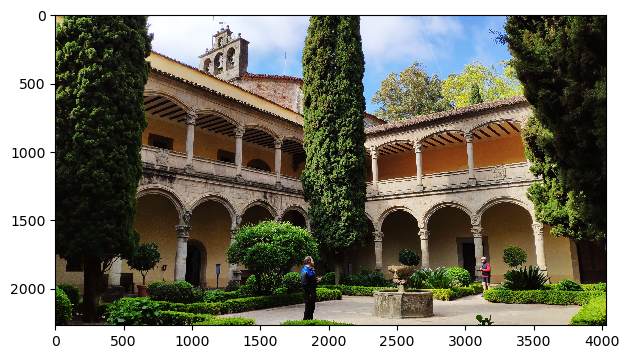

In [37]:
dataframe = getData()
for i in range(len(dataframe.index)):
    # On télécharge l'image
    link = dataframe._get_value(i,"link")
    path = dataframe._get_value(i,"path")
    response = urllib.request.urlretrieve(link, path)


 
img = io.imread(path)
io.imshow(img)

### Récupération des Données EXIFS

In [27]:
dataframe = getData()

wantedExifs = [274, 315, 306, 272]
columnNames = ["orientation", "artist", "dateTaken", 'appareil']

for i,tag in enumerate(wantedExifs):
    dataframe[columnNames[i]] = None
    

# On parcourt les entrées
for i in range(len(dataframe.index)):
    path = dataframe._get_value(i,"path")
    img = PIL.Image.open(path)
    exif_data = img._getexif()
    img.close()

    dataframe.at[i, "size"] = img.size
    if img.size[0] < img.size[1]:
        dataframe.at[i, "orientation"] = 0
    else:
        dataframe.at[i, "orientation"] = 1

    if exif_data:
      for tag in exif_data:
            if tag in wantedExifs:
                dataframe.at[i, columnNames[wantedExifs.index(tag)]] = exif_data[tag]
                
dataframe.astype({'orientation': 'int32'})

# On enregistre les données au format JSON
saveData(dataframe)
        
dataframe 


,label,link,entityID,format,path,size,sizeCategory,tags,year,style,orientation,artist,dateTaken,appareil
0,Basilica of Candelaria,http://commons.wikimedia.org/wiki/Special:File...,Q34485,jpg,./images/Basilica of Candelaria.jpg,"(2307, 1689)",NaN,[#monument],1959.0,[Q54111],1,None,2012:05:05 19:07:51,DMC-G1
1,Cathedral of La Laguna,http://commons.wikimedia.org/wiki/Special:File...,Q34562,jpg,./images/Cathedral of La Laguna.jpg,"(9003, 7203)",NaN,[#monument],1515.0,"[Q54111, Q186363, Q54111, Q186363]",1,None,2022:03:22 20:23:18,ILCE-6500
2,Church of San Salvador de Priesca,http://commons.wikimedia.org/wiki/Special:File...,Q1130947,jpg,./images/Church of San Salvador de Priesca.jpg,"(1772, 1255)",NaN,[#monument],901.0,[Q708807],1,None,2005:06:02 20:58:49,Canon EOS 10D
3,Hospital de los Reyes Católicos,http://commons.wikimedia.org/wiki/Special:File...,Q155443,jpg,./images/Hospital de los Reyes Católicos.jpg,"(3072, 2304)",NaN,[#monument],1511.0,[Q577852],1,None,2008:12:31 18:07:27,DMC-FZ8
4,Longoria Palace,http://commons.wikimedia.org/wiki/Special:File...,Q1164358,jpg,./images/Longoria Palace.jpg,"(4320, 3240)",NaN,[#monument],1904.0,[Q1295040],1,Luis Garcia ([[User:Zaqarbal|Zaqarbal]]),2011:02:13 04:52:20,DMC-ZX3
5,Monastery of San Miguel de Escalada,http://commons.wikimedia.org/wiki/Special:File...,Q203741,jpg,./images/Monastery of San Miguel de Escalada.jpg,"(3264, 2448)",NaN,[#monument],901.0,[Q1951304],1,None,2007:09:12 17:42:20,E-500
6,Monument to the Unknown Hero,http://commons.wikimedia.org/wiki/Special:File...,Q1187994,jpg,./images/Monument to the Unknown Hero.jpg,"(1999, 1499)",NaN,[#monument],1938.0,[Q54111],1,None,2006:09:04 20:04:41,Canon PowerShot A510
7,Palacio de la Condesa de Lebrija,http://commons.wikimedia.org/wiki/Special:File...,Q1064212,JPG,./images/Palacio de la Condesa de Lebrija.JPG,"(1728, 2304)",NaN,[#monument],1600.0,[Q4692],0,None,2007:03:11 13:29:53,DSC-P73
8,Panathenaic Stadium,http://commons.wikimedia.org/wiki/Special:File...,Q208811,jpg,./images/Panathenaic Stadium.jpg,"(2259, 653)",NaN,[#monument],-328.0,[Q331273],1,None,2011:10:27 19:02:56,None
9,Royal Convent of La Encarnación,http://commons.wikimedia.org/wiki/Special:File...,Q205524,jpg,./images/Royal Convent of La Encarnación.jpg,"(1595, 1138)",NaN,[#monument],1616.0,[Q840829],1,[[User:Zaqarbal|Zaqarbal]],2006:04:15 10:30:33,COACH 1.0                      


## 2. Annotation des images

### Fonction pour récupérer et ajouter le tag siècle

In [28]:
def find_century(year): #Permet de trouver le siècle à partir de l'année
    year = int(year)
    if (year <= 0): 
        cent_tag=("#Antiquité")
    elif (year <= 100):
        cent_tag ="#1er siècle"
    elif (year % 100 == 0):
        cent_tag="#"+str(year // 100)+"ème siècle"
    else:
        cent_tag="#"+str(year // 100 + 1)+"ème siècle"
    return cent_tag

def add_century_tag(dataframe): #Permet d'ajouter le tag siècle à chaque ligne du dataframe
    for i in range(len(dataframe.index)):
        year = dataframe._get_value(i,"year")
        if year is not None: #Prise en charge du cas où le monument n'a pas de date précise de construction
            dataframe.at[i, "tags"].append(find_century(year))
        else:
            dataframe.at[i, "tags"].append("#Inconnu")
    return dataframe

### Test Ajout du tag siècle

In [31]:
add_century_tag(dataframe)

,label,link,entityID,format,path,size,sizeCategory,tags,year,style
0,Castillo de Belmonte,http://commons.wikimedia.org/wiki/Special:File...,Q917896,jpg,./images/Castillo de Belmonte.jpg,(),None,"[#monument, #15ème siècle]",1456,[Q15011985]
1,Castle of the Marquises of the Vélez,http://commons.wikimedia.org/wiki/Special:File...,Q922097,JPG,./images/Castle of the Marquises of the Vélez.JPG,(),None,"[#monument, #16ème siècle]",1506,[Q4692]
2,Church of Nuestra Señora de la Asunción,http://commons.wikimedia.org/wiki/Special:File...,Q934947,jpg,./images/Church of Nuestra Señora de la Asunci...,(),None,"[#monument, #18ème siècle]",1764,"[Q37853, Q37853]"
3,Church of Santo Adriano de Tuñón,http://commons.wikimedia.org/wiki/Special:File...,Q942130,jpg,./images/Church of Santo Adriano de Tuñón.jpg,(),None,"[#monument, #9ème siècle]",801,[Q2748473]
4,Church of la Inmaculada Concepción,http://commons.wikimedia.org/wiki/Special:File...,Q965302,jpg,./images/Church of la Inmaculada Concepción.jpg,(),None,"[#monument, #15ème siècle]",1401,[Q2602891]
5,Hermitage of San Isidro,http://commons.wikimedia.org/wiki/Special:File...,Q920742,jpg,./images/Hermitage of San Isidro.jpg,(),None,"[#monument, #17ème siècle]",1650,[Q37853]
6,Hermitage of Santa María la Antigua,http://commons.wikimedia.org/wiki/Special:File...,Q926529,jpg,./images/Hermitage of Santa María la Antigua.jpg,(),None,"[#monument, #12ème siècle]",1200,[Q46261]
7,Hospital de la Santa Caridad,http://commons.wikimedia.org/wiki/Special:File...,Q858907,jpg,./images/Hospital de la Santa Caridad.jpg,(),None,"[#monument, #17ème siècle]",1682,[Q37853]
8,Monastery of Iranzu,http://commons.wikimedia.org/wiki/Special:File...,Q837979,jpg,./images/Monastery of Iranzu.jpg,(),None,"[#monument, #12ème siècle]",1176,[Q176483]
9,Plaza de España,http://commons.wikimedia.org/wiki/Special:File...,Q956018,jpg,./images/Plaza de España.jpg,(),None,"[#monument, #20ème siècle]",1928,"[Q5705264, Q5705264]"


### Test Ajout des tags country et style

In [32]:
AddCountryTags(dataframe)

,label,link,entityID,format,path,size,sizeCategory,tags,year,style
0,Castillo de Belmonte,http://commons.wikimedia.org/wiki/Special:File...,Q917896,jpg,./images/Castillo de Belmonte.jpg,(),None,"[#monument, #15ème siècle, #Espagne]",1456,[Q15011985]
1,Castle of the Marquises of the Vélez,http://commons.wikimedia.org/wiki/Special:File...,Q922097,JPG,./images/Castle of the Marquises of the Vélez.JPG,(),None,"[#monument, #16ème siècle, #Espagne]",1506,[Q4692]
2,Church of Nuestra Señora de la Asunción,http://commons.wikimedia.org/wiki/Special:File...,Q934947,jpg,./images/Church of Nuestra Señora de la Asunci...,(),None,"[#monument, #18ème siècle, #Espagne]",1764,"[Q37853, Q37853]"
3,Church of Santo Adriano de Tuñón,http://commons.wikimedia.org/wiki/Special:File...,Q942130,jpg,./images/Church of Santo Adriano de Tuñón.jpg,(),None,"[#monument, #9ème siècle, #Espagne]",801,[Q2748473]
4,Church of la Inmaculada Concepción,http://commons.wikimedia.org/wiki/Special:File...,Q965302,jpg,./images/Church of la Inmaculada Concepción.jpg,(),None,"[#monument, #15ème siècle, #Espagne]",1401,[Q2602891]
5,Hermitage of San Isidro,http://commons.wikimedia.org/wiki/Special:File...,Q920742,jpg,./images/Hermitage of San Isidro.jpg,(),None,"[#monument, #17ème siècle, #Espagne]",1650,[Q37853]
6,Hermitage of Santa María la Antigua,http://commons.wikimedia.org/wiki/Special:File...,Q926529,jpg,./images/Hermitage of Santa María la Antigua.jpg,(),None,"[#monument, #12ème siècle, #Espagne]",1200,[Q46261]
7,Hospital de la Santa Caridad,http://commons.wikimedia.org/wiki/Special:File...,Q858907,jpg,./images/Hospital de la Santa Caridad.jpg,(),None,"[#monument, #17ème siècle, #Espagne]",1682,[Q37853]
8,Monastery of Iranzu,http://commons.wikimedia.org/wiki/Special:File...,Q837979,jpg,./images/Monastery of Iranzu.jpg,(),None,"[#monument, #12ème siècle, #Espagne]",1176,[Q176483]
9,Plaza de España,http://commons.wikimedia.org/wiki/Special:File...,Q956018,jpg,./images/Plaza de España.jpg,(),None,"[#monument, #20ème siècle, #Espagne]",1928,"[Q5705264, Q5705264]"


In [35]:
AddStyleTags(dataframe)

,label,link,entityID,format,path,size,sizeCategory,tags,year,style
0,Castillo de Belmonte,http://commons.wikimedia.org/wiki/Special:File...,Q917896,jpg,./images/Castillo de Belmonte.jpg,(),None,"[#monument, #15ème siècle, #Espagne, #art mudé...",1456,[Q15011985]
1,Castle of the Marquises of the Vélez,http://commons.wikimedia.org/wiki/Special:File...,Q922097,JPG,./images/Castle of the Marquises of the Vélez.JPG,(),None,"[#monument, #16ème siècle, #Espagne, #Renaissa...",1506,[Q4692]
2,Church of Nuestra Señora de la Asunción,http://commons.wikimedia.org/wiki/Special:File...,Q934947,jpg,./images/Church of Nuestra Señora de la Asunci...,(),None,"[#monument, #18ème siècle, #Espagne, #baroque,...",1764,"[Q37853, Q37853]"
3,Church of Santo Adriano de Tuñón,http://commons.wikimedia.org/wiki/Special:File...,Q942130,jpg,./images/Church of Santo Adriano de Tuñón.jpg,(),None,"[#monument, #9ème siècle, #Espagne, #art astur...",801,[Q2748473]
4,Church of la Inmaculada Concepción,http://commons.wikimedia.org/wiki/Special:File...,Q965302,jpg,./images/Church of la Inmaculada Concepción.jpg,(),None,"[#monument, #15ème siècle, #Espagne, #Gothique...",1401,[Q2602891]
5,Hermitage of San Isidro,http://commons.wikimedia.org/wiki/Special:File...,Q920742,jpg,./images/Hermitage of San Isidro.jpg,(),None,"[#monument, #17ème siècle, #Espagne, #baroque,...",1650,[Q37853]
6,Hermitage of Santa María la Antigua,http://commons.wikimedia.org/wiki/Special:File...,Q926529,jpg,./images/Hermitage of Santa María la Antigua.jpg,(),None,"[#monument, #12ème siècle, #Espagne, #architec...",1200,[Q46261]
7,Hospital de la Santa Caridad,http://commons.wikimedia.org/wiki/Special:File...,Q858907,jpg,./images/Hospital de la Santa Caridad.jpg,(),None,"[#monument, #17ème siècle, #Espagne, #baroque,...",1682,[Q37853]
8,Monastery of Iranzu,http://commons.wikimedia.org/wiki/Special:File...,Q837979,jpg,./images/Monastery of Iranzu.jpg,(),None,"[#monument, #12ème siècle, #Espagne, #architec...",1176,[Q176483]
9,Plaza de España,http://commons.wikimedia.org/wiki/Special:File...,Q956018,jpg,./images/Plaza de España.jpg,(),None,"[#monument, #20ème siècle, #Espagne, #regional...",1928,"[Q5705264, Q5705264]"


## Analyse des Données

### Kmeans et Couleurs dominantes

In [39]:
dataframe = getData()
dataframe["dColors"] = None
dataframe["dProportions"] = None

nColors = 6
laziness = 100

kmeans = KMeans(n_clusters=nColors, random_state=0, n_init="auto")


for i, path in enumerate(dataframe["path"]):
    img = PIL.Image.open(path).convert('RGB')
    pixelData = numpy.array(img).reshape(-1, 3)[::laziness]
    kmeans.fit(pixelData)

    proportions = numpy.array([0 for i in range(nColors)])
    for x in kmeans.labels_:
        proportions[x] += numpy.float64(1)
    proportions = proportions / kmeans.labels_.size

    dataframe.at[i,"dColors"] = numpy.int32(kmeans.cluster_centers_)
    dataframe.at[i,"dProportions"] = proportions
    
saveData(dataframe)

dataframe

C:\Users\tomgr\Documents\Dev\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\tomgr\Documents\Dev\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,label,link,entityID,format,path,size,sizeCategory,tags,year,style,dColors,dProportions
0,Castillo de Belmonte,http://commons.wikimedia.org/wiki/Special:File...,Q917896,jpg,./images/Castillo de Belmonte.jpg,[],NaN,[#monument],1456.0,[Q15011985],"[[122, 101, 83], [180, 159, 132], [83, 110, 16...","[0.13343328335832083, 0.1916041979010495, 0.32..."
1,Castle of the Marquises of the Vélez,http://commons.wikimedia.org/wiki/Special:File...,Q922097,JPG,./images/Castle of the Marquises of the Vélez.JPG,[],NaN,[#monument],1506.0,[Q4692],"[[227, 227, 235], [67, 66, 51], [112, 103, 88]...","[0.2899373372395833, 0.16343180338541666, 0.12..."
2,Church of Nuestra Señora de la Asunción,http://commons.wikimedia.org/wiki/Special:File...,Q934947,jpg,./images/Church of Nuestra Señora de la Asunci...,[],NaN,[#monument],1764.0,"[Q37853, Q37853]","[[43, 36, 48], [155, 198, 219], [145, 124, 114...","[0.12368073878627968, 0.14528364116094986, 0.1..."
3,Church of Santo Adriano de Tuñón,http://commons.wikimedia.org/wiki/Special:File...,Q942130,jpg,./images/Church of Santo Adriano de Tuñón.jpg,[],NaN,[#monument],801.0,[Q2748473],"[[68, 69, 63], [226, 206, 187], [196, 163, 113...","[0.1779315960912052, 0.2284201954397394, 0.173..."
4,Church of la Inmaculada Concepción,http://commons.wikimedia.org/wiki/Special:File...,Q965302,jpg,./images/Church of la Inmaculada Concepción.jpg,[],NaN,[#monument],1401.0,[Q2602891],"[[41, 32, 33], [182, 185, 205], [136, 126, 126...","[0.15104166666666666, 0.05078125, 0.2265625, 0..."
5,Hermitage of San Isidro,http://commons.wikimedia.org/wiki/Special:File...,Q920742,jpg,./images/Hermitage of San Isidro.jpg,[],NaN,[#monument],1650.0,[Q37853],"[[105, 78, 90], [239, 230, 230], [48, 47, 99],...","[0.23773898586866168, 0.10972568578553615, 0.1..."
6,Hermitage of Santa María la Antigua,http://commons.wikimedia.org/wiki/Special:File...,Q926529,jpg,./images/Hermitage of Santa María la Antigua.jpg,[],NaN,[#monument],1200.0,[Q46261],"[[68, 134, 212], [114, 105, 91], [243, 241, 23...","[0.12836162502384132, 0.21587513510076928, 0.1..."
7,Hospital de la Santa Caridad,http://commons.wikimedia.org/wiki/Special:File...,Q858907,jpg,./images/Hospital de la Santa Caridad.jpg,[],NaN,[#monument],1682.0,[Q37853],"[[187, 198, 215], [25, 19, 15], [135, 137, 140...","[0.16119486264858562, 0.13662405468150612, 0.1..."
8,Monastery of Iranzu,http://commons.wikimedia.org/wiki/Special:File...,Q837979,jpg,./images/Monastery of Iranzu.jpg,[],NaN,[#monument],1176.0,[Q176483],"[[53, 45, 40], [211, 192, 182], [173, 153, 135...","[0.10439106045056445, 0.12020366071161682, 0.1..."
9,Plaza de España,http://commons.wikimedia.org/wiki/Special:File...,Q956018,jpg,./images/Plaza de España.jpg,[],NaN,[#monument],1928.0,"[Q5705264, Q5705264]","[[26, 16, 13], [84, 78, 78], [140, 102, 45], [...","[0.32736683702706354, 0.13186081074155692, 0.0..."


In [ ]:
# Création de la dataframe des utilisateurs

array = [['default',[],[]]]
usersDataframe = pandas.DataFrame(array, columns=['name', 'likes','dislikes'])

saveUsers(usersDataframe)

usersDataframe

In [ ]:
def addUser(name):
    usersDf = getUsers()
    usersDf.loc[len(usersDf.index)] = [name,[],[]] 
    saveUsers(usersDf)
    

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def getRecommandation(user):

    likedImages = getUsers()["likes"][getUsers().index["name" == user].tolist()[0]]
    dislikedImages = getUsers()["dislikes"][getUsers().index["name" == user].tolist()[0]]

    trainDataIndexes = likedImages + dislikedImages
    result = []
    for i in trainDataIndexes:
        if i in likedImages:
            result.append("likes")
        else:
            result.append("dislikes")
    
    data = numpy.array(getData()[['tags','orientation']])
    trainData = [trainData[i] for i in trainDataIndexes]
    
    for i in range(trainData.shape[0]):
        for j in range(trainData.shape[1]):
            trainData[i][j] = str(trainData[i][j])


    # Encode categorical features and labels
    label_encoders = [LabelEncoder() for _ in range(len(trainData[0]))]
    encoded_data = []
    for i, column in enumerate(zip(*trainData)):
        encoded_data.append(label_encoders[i].fit_transform(column))

    X = list(zip(*encoded_data))  # Features
    y = result  # Labels


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = svm.SVC()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # prediction
    for item in data:

        sample_item = numpy.array(getData()[['tags','orientation']])[-1]
        sample_item = [str(attribute) for attribute in sample_item]

    encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
    prediction = classifier.predict([encoded_item])[0]
    print(f"Prediction for the sample item: {prediction}")


## Visualisation des Données

In [ ]:
dataframe = getData()

criteriaToColumn = {'year':'dateTaken', 'orientation':'orientation'}
criteria = ''
while criteria not in criteriaToColumn :
    criteria = input('criteria :')


categories = ['unknown']
cardinals  = [0]


for i in range(len(dataframe.index)):
    value = str(dataframe._get_value(i, criteriaToColumn[criteria]))

    if value != 'None':
        if criteria == 'year':
            value = value.split(':')[0].strip()
        elif criteria == 'orientation':
            value = {'0':"Portrait", '1':"Landscape"}[value]

        if value in categories:
            cardinals[categories.index(value)] += 1
        else:
            categories.append(value)
            cardinals.append(1)
    else:
        cardinals[0] += 1


plt.bar(categories, cardinals)

In [ ]:
dataframe = getData()

imageIndex = randint(0, len(dataframe['label']))

fig, ax = plt.subplots(1,2)

ax[0].pie(dataframe.at[imageIndex,"dProportions"], colors=(numpy.array(dataframe.at[imageIndex, "dColors"])/255))
ax[1].imshow(PIL.Image.open(dataframe.at[imageIndex, "path"]))


## Application

In [ ]:
wTab = ipywidgets.widgets.Tab()
currentUser = 'default'


# UsersWidget
wCurrentUser = ipywidgets.widgets.Dropdown(
    options=getUsers()['name'],
    value='default',
    description='Current User :',
    disabled=False
)
def updateCurrentUser(tmp):
    global currentUser
    currentUser = wCurrentUser.value
wCurrentUser.observe(updateCurrentUser)

def updateUserWidget():
    wCurrentUser.options = getUsers()['name']

# Create User Tab
wUsername = ipywidgets.widgets.Text(
    value='',
    placeholder='',
    description='Username:',
    disabled=False   
)
wBtnCreateUser = ipywidgets.widgets.Button(
    description='Create',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Creates a new user',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def createUser(tmp):
    newUser = wUsername.value
    addUser(newUser)
    updateUserWidget()


wBtnCreateUser.on_click(createUser)

wBoxCreateUser = ipywidgets.HBox([wUsername,wBtnCreateUser])

# Random Images Tab
dataframe = getData()
imagePaths = dataframe['path']

wBtnGetRnd = ipywidgets.widgets.Button(description="Get new random Images")
wBtnSelect = ipywidgets.widgets.Button(description="Validate Likes")



rowArray = [wBtnGetRnd]
wCheckArray = []
wImgLayout = ipywidgets.Layout(width = '60%')
cellLayout = ipywidgets.Layout(width = '50%', border = '3px')
def getRandomImages(tmp):
    cellArray = []

    global rowArray
    global wCheckArray

    rowArray = [wBtnGetRnd]
    wCheckArray = []

    for i,path in enumerate(imagePaths[:7]):
        with open(path, "rb") as f :
            wImg   = ipywidgets.widgets.Image(value=f.read(), layout = wImgLayout)
            wCheckArray.append(ipywidgets.Checkbox())
            cellArray.append(ipywidgets.HBox([wImg, wCheckArray[-1]], layout = cellLayout))
        if (i+1)%3 == 0:
            rowArray.append(ipywidgets.HBox(cellArray))
            cellArray = []
    rowArray.append(wBtnSelect)
    updateTab(rowArray)

wBtnGetRnd.on_click(getRandomImages)


def get_likes(btn):
    likedImagePaths    = [imagePaths[i] for i, wCheck in enumerate(wCheckArray) if wCheck.value]
    dislikedImagePaths = [path for path in imagePaths if(path not in likedImagePaths)]

    likedImages    = [dataframe.index[dataframe['path'] == path].tolist()[0] for path in likedImagePaths]
    dislikedImages = [dataframe.index[dataframe['path'] == path].tolist()[0] for path in dislikedImagePaths]
    
    
    usersDf = getUsers()
    currentUserIndex = usersDf.index[usersDf['name'] == currentUser].tolist()[0]
    usersDf['likes'][currentUserIndex] = likedImages
    usersDf['dislikes'][currentUserIndex] = dislikedImages
    saveUsers(usersDf)
    print(usersDf)


wBtnSelect.on_click(get_likes)


def updateTab(rowArray):
    wTab.children = [wBoxCreateUser, ipywidgets.VBox(rowArray)]
    wTab.titles   = ['User', 'Random Images']

    return ipywidgets.VBox([wCurrentUser, wTab])


updateTab(rowArray)

